In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import scipy

In [2]:
u= np.ones(400)
#make random step signals
u[0:20] = 0
u[100:110]=0
u[200:250]=0
ts = range(400)

In [3]:
%matplotlib inline

the curve fit funtionc works better than a "commmerical identification package"  in case of noisy data. The aida parameters for noisy data are 3.9 and 8

Interpolation basically coversters an array of x and y , to a function. An array of x and y , consists of mappings x and y values only for specific values of x , but function takes an argument and returns result , for any value of x. The interplation does not support indexing , as it is a function

In [4]:
def fopdt(u,k,tau,dt):
    y = 0
    ys = []
    ts = range(400)
    uf= interp1d(ts,u)
    for t in ts:
    
        if (t-dt) < 0:
            dydt=0
        else:
            dydt = (-1/tau)*y + (k/tau)*uf(t-dt) # look at the brackets  , instead of square brackets. 
            
            y += dydt
        ys.append(y)
    y_arr = np.array(ys)
    return y_arr

now let us do this using numpy arrays. to make it more efficient . The key point to remember that , to avoid the for loops and "append" operations, specify the size of the whole numpy array initially , and then change the elements slice by slice. 

def fopdt(u,k,tau,dt):
    y = 0
    ys = np.zeros(400)
    ts = range(400)
    uf= interp1d(ts,u)
    if (t-dt) < 0:
        dydt[:dt]=0
    else:
        dydt[dt+1:] = (-1/tau)*y + (k/tau)*uf(t-dt) # look at the brackets  , instead of square brackets. 
    y += dydt
        ys.append(y)
    y_arr = np.array(ys)
    return y_arr

In [5]:
y = fopdt(u,4,10,20)

In [6]:
yn = np.random.rand(400)+y

In [7]:
popt,pcov =scipy.optimize.curve_fit(fopdt,u,yn,bounds=([-10000,0.1,0],[10000,600,100]))

In [8]:
popt

array([  4.60108259,  12.41403886,  18.81818349])

In [9]:
def residuals(p):
    k,tau,dt = p
    err = np.sum((yn- fopdt(u,k,tau,dt))**2)
    return err

In [10]:
popt1 = scipy.optimize.minimize(residuals,x0=(1,1,1),bounds=((-10000,10000),(0.01,600),(0,100)))

In [11]:
popt1.x

array([  4.60108109,  12.41396385,  18.81821108])

curve_fit and scipy.optimize.minimize give exactly the same solutions. 

if the output is without noise, then

In [12]:
def residuals(p):
    k,tau,dt = p
    err = np.sum((y- fopdt(u,k,tau,dt))**2)
    return err

In [13]:
popt1 = scipy.optimize.minimize(residuals,x0=(1,1,1),bounds=((-10000,10000),(0.01,600),(0,100)))

In [14]:
popt1.x

array([  3.99999999,   9.99999984,  20.00000011])

In [15]:
def residuals(p):
    k,tau,dt = p
    ym = fopdt(u,k,tau,dt)
    ydt = yn[int(dt):] # slice of y , that starts after the delay time. 
    ymdt = ym[int(dt):] # slice of ym , that starts after the delay time. 
    err = np.sum((ydt -ymdt )**2)/ydt.size
    return err

In [16]:
popt1 = scipy.optimize.minimize(residuals,x0=(1,1,1),bounds=((-10000,10000),(0.01,600),(0,100)))

In [17]:
popt1.x

array([  4.60112605,  12.41617031,  18.81751254])

let us create a deviation variable , for y , so that , the first value of y is zero 

In [18]:
ydev = yn -yn[0]

In [19]:
def residuals(p):
    k,tau,dt = p
    ym = fopdt(u,k,tau,dt) 
    ymdev = ym -ym[0]
    err = np.sum((ydev- ymdev)**2)
    return err

In [20]:
popt1 = scipy.optimize.minimize(residuals,x0=(1,1,1),bounds=((-10000,10000),(0.01,600),(0,100)))

In [21]:
popt1.x

array([  4.22439063,  10.93859959,  19.67360926])

very good improvment with deviation variable fitting,i see that , the initial value of y , makes a big difference in identification in noisy data. 

aida parameters ar 4.063,10.03, 18.87

next , we will try to model the noise , and remove the noise, then model 
two kinds of noise 
1. drifting 
2. random 

assuming , that there is only random noise , how to model this noise ? Gaussian filter ?

In [22]:
%timeit popt,pcov =scipy.optimize.curve_fit(fopdt,u,ydev,bounds=([-10000,0.1,0],[10000,600,100]))

1.28 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
popt

array([  4.60108259,  12.41403886,  18.81818349])

In [24]:
%timeit popt,pcov =scipy.optimize.curve_fit(fopdt,u,ydev,p0=[4,10,20],bounds=([-10000,0.1,0],[10000,600,100]))


422 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


the initial conditions do make a difference  , in the speed of execution , but no difference in solution.


In [25]:
popt

array([  4.60108259,  12.41403886,  18.81818349])

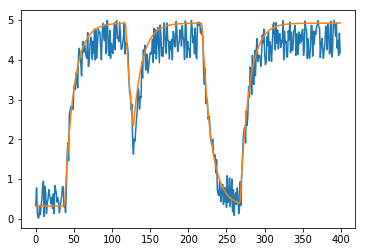

In [26]:
plt.plot(yn)
plt.plot(yn[0]+fopdt(u,popt[0],popt[1],popt[2]))

In [27]:
def stepresponse(p,horizon):
    k,tau,dt = p
    u = np.ones(horizon)
    y = 0
    ys = []
    ts = range(horizon)
    uf= interp1d(ts,u)
    for t in ts:
    
        if (t-dt) < 0:
            dydt=0
        else:
            dydt = (-1/tau)*y + (k/tau)*uf(t-dt) # look at the brackets  , instead of square brackets. 
            
            y += dydt
        ys.append(y)
    plt.plot(ys)
    

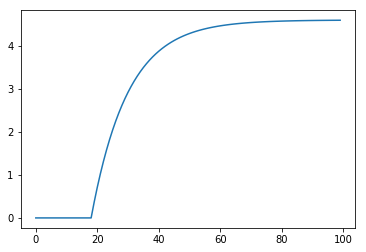

In [28]:
stepresponse(popt,100)

things to do
1. MIMO identification
2. detrending, drifting 
3. optimization with numpy array
4. closed loop identification.


In [ ]:
def stepresponse(p,horizon):
    k0,tau0,dt0 = p[0]
    k1,tau1,dt1 = p[1]
    
    u = np.ones(horizon)
    y = 0
    ys = []
    ts = range(horizon)
    uf= interp1d(ts,u)
    for t in ts:
    
        if (t-dt) < 0:
            dydt=0
        else:
            dydt = (-1/tau)*y + (k/tau)*uf(t-dt) # look at the brackets  , instead of square brackets. 
            
            y += dydt
        ys.append(y)
    plt.plot(ys)